In [4]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.chdir("/home/jovyan/work/Face_Mask_Detection")
# !pwd

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import utils
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

# Start

In [4]:
import xmltodict
def fileToDict(path):
    with open(path, "r") as file:
        _dict = xmltodict.parse(file.read())
    return _dict

In [57]:
def get_data(num):
    xml_path = f"dataset/annotations/maksssksksss{num}.xml"
    images_path = f"dataset/images/maksssksksss{num}.png"
    data = fileToDict(xml_path)["annotation"]
    shape = (int(data["size"]["height"]), int(data["size"]["width"]), int(data["size"]["depth"]))
    bboxs = []
    status = []
    if type(data["object"]) != list:
        obj = data["object"]
        status.append(obj["name"])
        xmin = int(obj["bndbox"]["xmin"])
        ymin = int(obj["bndbox"]["ymin"])
        xmax = int(obj["bndbox"]["xmax"])
        ymax = int(obj["bndbox"]["ymax"])
        bboxs.append((xmin, ymin, xmax, ymax))
    else:
        for obj in data["object"]:
            status.append(obj["name"])
            xmin = int(obj["bndbox"]["xmin"])
            ymin = int(obj["bndbox"]["ymin"])
            xmax = int(obj["bndbox"]["xmax"])
            ymax = int(obj["bndbox"]["ymax"])
            bboxs.append((xmin, ymin, xmax, ymax))

    for i in range(len(status)):
        if status[i] == "with_mask": status[i] = 0
        elif status[i] == "without_mask": status[i] = 1
        elif status[i] == "mask_weared_incorrect": status[i] = 2
    dataset = {
        "image_path": [images_path],
        # "shape": [shape],
        "status": [status],
        "bboxs": [bboxs]
    }
    # return dataset
    return pd.DataFrame(dataset)

# dataset = pd.DataFrame(get_data(1))
# dataset.shape
get_data(0)

,image_path,status,bboxs
0,dataset/images/maksssksksss0.png,"[1, 0, 1]","[(79, 105, 109, 142), (185, 100, 226, 144), (3..."


In [58]:
def get_datas(start, end):
    data = get_data(start)
    for i in range(start + 1, end):
        data = pd.concat([data, get_data(i)], ignore_index=True)
    return data

In [59]:
get_datas(0, 5)

,image_path,status,bboxs
0,dataset/images/maksssksksss0.png,"[1, 0, 1]","[(79, 105, 109, 142), (185, 100, 226, 144), (3..."
1,dataset/images/maksssksksss1.png,"[0, 0, 0, 0, 0, 0, 0, 0, 1]","[(321, 34, 354, 69), (224, 38, 261, 73), (299,..."
2,dataset/images/maksssksksss2.png,"[0, 0, 0, 2]","[(68, 42, 105, 69), (154, 47, 178, 74), (238, ..."
3,dataset/images/maksssksksss3.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[(52, 53, 73, 76), (72, 53, 92, 75), (112, 51,..."
4,dataset/images/maksssksksss4.png,[0],"[(70, 185, 176, 321)]"


In [62]:
data = get_datas(0, 5)

In [63]:
data.iloc[:, 0]

0    dataset/images/maksssksksss0.png
1    dataset/images/maksssksksss1.png
2    dataset/images/maksssksksss2.png
3    dataset/images/maksssksksss3.png
4    dataset/images/maksssksksss4.png
Name: image_path, dtype: object

In [64]:
data.iloc[:, 1:]

,status,bboxs
0,"[1, 0, 1]","[(79, 105, 109, 142), (185, 100, 226, 144), (3..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]","[(321, 34, 354, 69), (224, 38, 261, 73), (299,..."
2,"[0, 0, 0, 2]","[(68, 42, 105, 69), (154, 47, 178, 74), (238, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[(52, 53, 73, 76), (72, 53, 92, 75), (112, 51,..."
4,[0],"[(70, 185, 176, 321)]"


In [ ]:
labels = ("without_mask", "with_mask", "mask_weared_incorrect")
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

ImageDataGenerator詳細：https://zhuanlan.zhihu.com/p/30197320

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=10,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=100, class_mode="categorical", target_size=(64, 64))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=20, class_mode="categorical", target_size=(64, 64))

train_num = 3260

加載VGG19預訓練模型：https://blog.csdn.net/dcrmg/article/details/81178424

80150528/80134624 [==============================] - 1s 0us/step


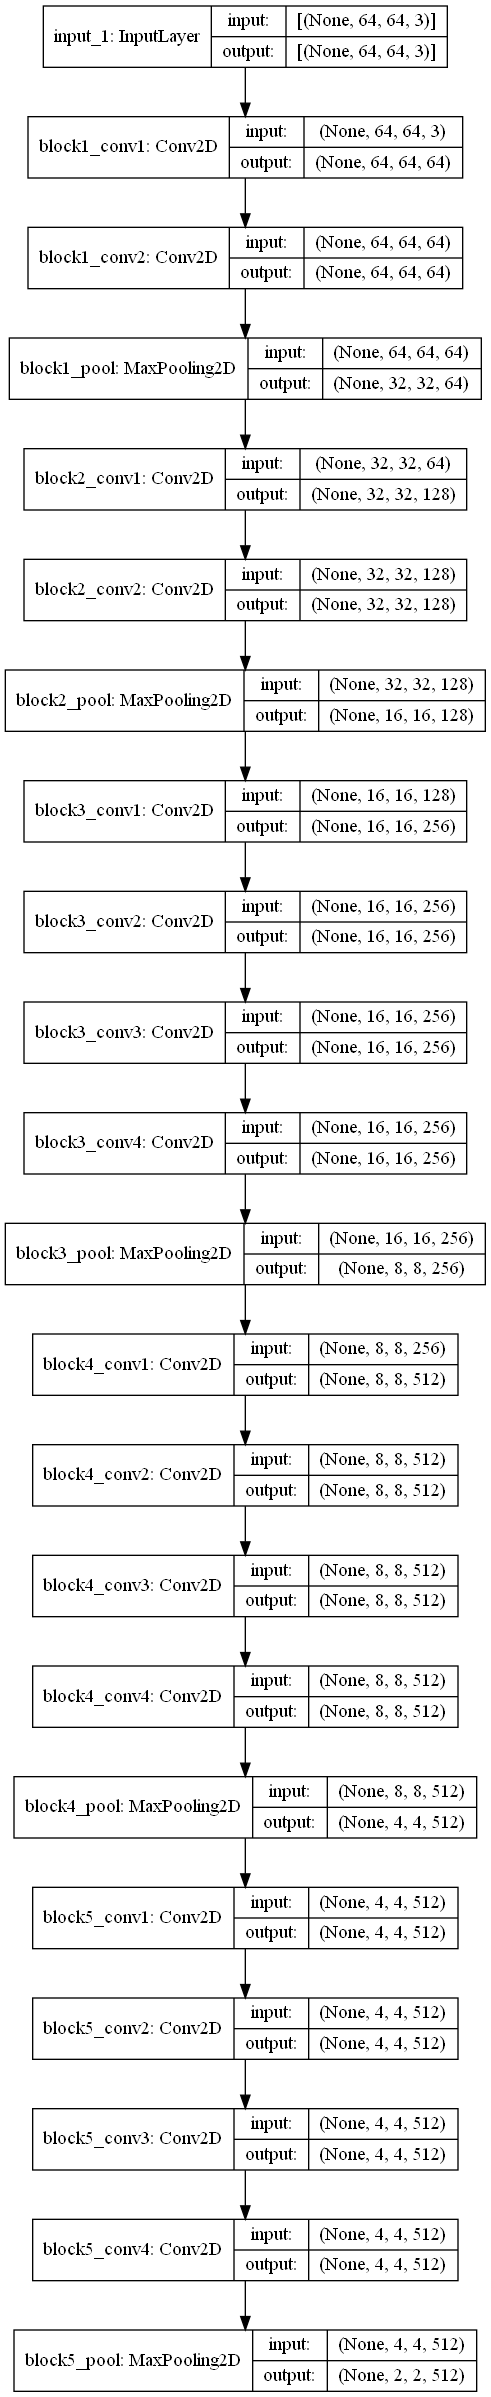

In [68]:
base_model = VGG19(weights="imagenet", input_shape=(64, 64, 3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False
plot_model(base_model, show_shapes=True)

如何去掉模型的全連接層：https://blog.csdn.net/qq_29462849/article/details/83010854

In [75]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(2048, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(1024, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(512, activation="relu", kernel_initializer="he_normal"),
    # layers.Dropout(0.2),
    layers.Dense(4, activation="softmax")
])
model.summary()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

ReduceLROnPlateau待測試：https://hackmd.io/@allen108108/SyCsOIkxB

In [ ]:
model_tag = 'model_2'
models_dir = 'models'
model_dir = os.path.join(models_dir, model_tag)
callbacks = []
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="loss", patience=100, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'model.h5'
filepath = os.path.join(model_dir, model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.h5'
filepath = os.path.join(model_dir, "checkpoint", model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(models_dir, 'logs', model_tag)
callbacks.append(
  keras.callbacks.TensorBoard(log_dir=log_dir)
)
''' trainParam '''
batch_size = 1000
epochs = 1000
steps_per_epoch = int(train_num / batch_size)
print(f'steps_per_epoch = {steps_per_epoch}')
print(f'filepath = {filepath}')

# Train

In [ ]:
trainHistory = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Result

In [ ]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(trainHistory.history['categorical_accuracy'], color='r', label='categorical_accuracy')
plt.plot(trainHistory.history['val_categorical_accuracy'], color='b', label='val_categorical_accuracy')
plt.legend()
plt.show()

# Test

In [ ]:
best_model = load_model(f"models/{model_tag}/model.h5")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=False, batch_size=406, class_mode="categorical", target_size=(64, 64))
Y_test_classes = np.argmax(test_generator[0][1], 1)

In [ ]:
loss, categorical_accuracy = best_model.evaluate(test_generator)
print(f"ACC = {categorical_accuracy * 100:.4f} %")

In [ ]:
predicts = best_model.predict(test_generator)
predicts_classes = np.argmax(predicts, 1)
utils.plot_confusion_matrix(Y_test_classes, predicts_classes, 3)

In [ ]:
for i, cls in enumerate(labels):
    print(f"{i}. {cls}")